In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import IPython.display as ipd

def play(x, sr=44100):
    return ipd.Audio(x, rate=sr)

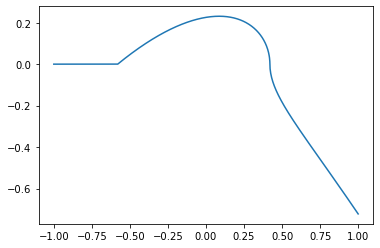

In [4]:
# paramètres
P_M = 75e3  # pression de plaquage
gamma = .42  # pression bouche / P_M
zeta = .6  # force d'appui de la lèvre adimensionné

def F(p, gamma=.42, zeta=.6):
    sub = gamma - p
    sign = sub / abs(sub)
    u = zeta * (1 - sub) * (abs(sub)) ** (1 / 2) * sign * (sub < 1)
    #u[sub >= 1] = 0
    return u

x = np.linspace(-1, 1, 1000)
plt.plot(x, F(x))

-0.5


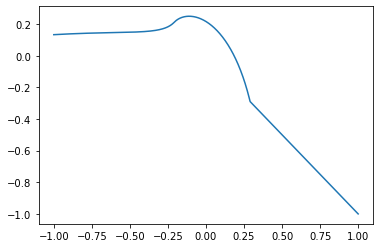

In [14]:
def G(_p_moins, gamma=.42, zeta=.6):
    
    # turn into numpy array
    _p_moins = np.atleast_1d(_p_moins)
    
    # change of variables
    Y = gamma + 2 * _p_moins
    X = np.empty(Y.shape)
    
    # extra useful variables
    psi= 1 / zeta ** 2
    eta = (3 + psi) ** (1 / 2)
    mu = 9 / 2 * (3 * Y - 1)
    
    # case 1: 1 <= Y
    cond = (1 <= Y)
    X[cond] = Y[cond]
    
    # case 2: 0 < Y < 1
    cond = np.logical_and(0 < Y, Y < 1)
    X[cond] = (- 2/3 * eta * np.sin(1 / 3 * np.arcsin((psi - mu[cond]) / (zeta * eta ** 3))) + 1 / (3 * zeta)) ** 2

    # case 3 : Y < 0
    cond = Y < 0
    q = 1 / 9 * (3 - psi)
    r = - (psi + mu) / (27 * zeta)
    discr = q ** 3 + r ** 2
    cond_discr = discr > 0
    
    # discriminant is positive
    cond_tot = np.logical_and(cond, cond_discr)
    s1 = (r[cond_tot] + discr[cond_tot] ** (1 / 2)) ** (1 / 3)
    X[cond_tot] = -(s1 - q / s1 - 1 / (3 * zeta)) ** 2
    
    # discrumunant is negative
    cond_tot = np.logical_and(cond, ~cond_discr)
    eta_prime = (-3 + psi) ** (1 / 2)
    X[cond_tot] = -(2 / 3 * eta_prime * np.cos(1 / 3 * np.arccos(-(psi + mu[cond_tot]) / (zeta * eta_prime ** 3))) - 1 / (3 * zeta)) ** 2 
    
    # change variables back
    p_plus = -X + gamma + _p_moins
    if p_plus.size == 1:
        p_plus = p_plus.item()
    
    return p_plus

x = np.linspace(-1, 1, 1000)
plt.plot(x, G(x))
print(G(0.5, 0.42, 0.6))

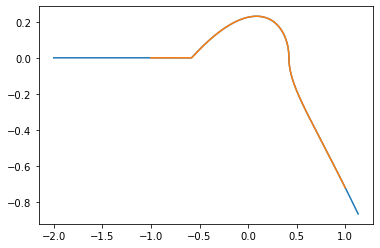

In [6]:
# sanity check
x = np.linspace(-1, 1, 1000)

p = G(x) - x
u = G(x) + x
plt.plot(p, u)
plt.plot(x, F(x))

In [6]:
def refl_dirac(lambda_=.9, L=.66, c=340, sr=44100):
    
    num_samples = int(2 * L / c * sr)
    refl = np.zeros(num_samples)
    refl[-1] = -lambda_
    return refl


def refl_gauss(std=10, lambda_=.9, L=.66, c=340, sr=44100):
    
    num_samples = int(2 * L / c * sr)
    radius = -int(norm.ppf(0.001, scale=std))    
    
    x = np.arange(-radius, radius + 1)
    bell = -lambda_ * norm.pdf(x, scale=std)
    
    refl = np.concatenate((np.zeros(num_samples - radius), bell))
    return refl

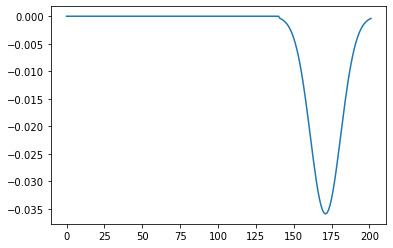

In [7]:
#refl_gauss().shape
plt.plot(refl_gauss())

In [8]:
def sound(t, refl, gamma=.42, zeta=.6, sr=44100, P_M=75e3):
    
    p_plus = np.empty(int(t * sr))
    p_moins = np.empty(int(t * sr))
    buff_len = len(refl)
    
    p_moins[:buff_len] = 0
    p_plus[:buff_len] = G(0, gamma, zeta)
    
    for i in range(buff_len, len(p_plus) - 1):
        p_moins[i] = refl[::-1] @ p_plus[i - buff_len:i]
        p_plus[i] = G(-p_moins[i])
    
    p = p_plus + p_moins
    #sound = p * P_M
    
    return p[buff_len:]

In [9]:
x = sound(5, refl_gauss(), gamma=.62, zeta=.6)
play(x)

In [28]:
sr = 5000
refl = refl_gauss(std=1, sr=sr)
x = sound(5, refl, gamma=.47, zeta=.3, sr=sr)
play(x, sr=sr)

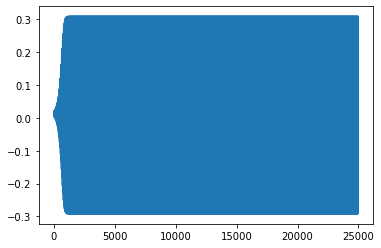

In [29]:
#plt.plot(x[:])

#import scipy.io.wavfile as wavfile

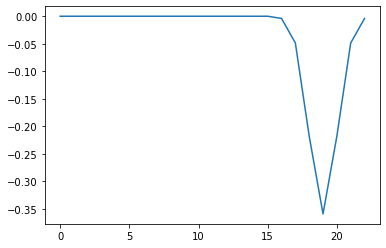

In [27]:
#plt.plot(refl_gauss(std=1, sr=5000))

In [12]:
#rho = 1.225 # masse volumique de l'air
#c = 340 # célérité des ondes dans l'air
#S = 7e-3 ** 2 * np.pi # surface section
#imp_char = rho * c / S

In [30]:
#wavfile.write('test.wav', rate=sr, data=x)